# Askbot using PandasAI library

The motivation of the exercise is to parse the audio from the microphone to text, and and ask to OpenAI model what you said.

### Imports 

I wrote every key i need to use the API's like pandasai or openai into a .env file in my root project directory, if u want to use the app you should make one or copy my method

In [14]:
# PandasAI
import os
import pandas as pd
import pandasai
from pandasai import SmartDataframe
from pandasai.llm.openai import OpenAI
from dotenv import dotenv_values
# # Audio detection
import pyaudio
import wave
import audioop
import webrtcvad
# Speech2Text and Text2Speech
import speech_recognition as sr
import pyttsx3
# Keys
keys = dotenv_values("../../.env-token")

### Global Parameters

In [50]:
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
CHUNK = 320
THRESHOLD = 500
SILENCE_TIMEOUT = 1

### Initialization


In [26]:
# Environment key
os.environ["PANDASAI_API_KEY"] = keys["PANDASAI_API_KEY"]
llm = OpenAI(api_token=keys["OPENAI_API_KEY"])

### Record

In [65]:
# This will record audio till we stay 4 seconds without talk
audio = pyaudio.PyAudio()
stream = audio.open(
    format=FORMAT,
    channels=CHANNELS,
    rate=RATE,
    input=True,
    frames_per_buffer=CHUNK
)
print("You can talk now.\nRecording...")
#
frames = []
silence_counter = 0
vad = webrtcvad.Vad()
vad.set_mode(3) # <-- Aggressive detection to record voice

try:
    while True:
        data = stream.read(CHUNK)
        frames.append(data)
        is_speech = vad.is_speech(data, RATE)
        if not is_speech:
            silence_counter += 1
        else:
            silence_counter = 0
        if silence_counter >= int( SILENCE_TIMEOUT * ( RATE / CHUNK )):
            break
except Exception as e:
    print(f"Exception catched: {e}")

print("\nFinished recording.")

# Stop stream
stream.stop_stream()
stream.close()

# Stop PyAudio
audio.terminate()

# Save the recorded audio as .wav file
with wave.open("Audios/recorded_audio.wav", "wb") as audio_recorded:
    audio_recorded.setnchannels(CHANNELS)
    audio_recorded.setsampwidth(audio.get_sample_size(FORMAT))
    audio_recorded.setframerate(RATE)
    audio_recorded.writeframes(b"".join(frames))

You can talk now.
Recording...

Finished recording.


After we record and saved the audio we still have to process it with speech2text and ask the question to OpenAI.

When we complete every step, the we would just have convert to speech the generated text and play it (text2speech)

### Speech2Text + Text2Speech

##### Functions

In [47]:

r = sr.Recognizer()
# This function says everything that is in text variable
def Text2Speech(text):
    engine = pyttsx3.init()
    engine.say(text)
    engine.runAndWait()
    
def Speech2Text(audioFile):
    with sr.AudioFile(audioFile) as audio:
        audioFile = r.record(audio)
        print("Audio loaded")
        try:
            text = r.recognize_google(audioFile)
            print(text)
            return text
        except Exception as e:
            print(e)
            return e
    


#### Transform Speech from previus audio into text

In [66]:
# speech2text try
text = Speech2Text("Audios/recorded_audio.wav")
type(text)

Audio loaded
can you make a plot about the average salary in it companies


str

#### Ask PandasAI

In [61]:
empty_df = [{}]

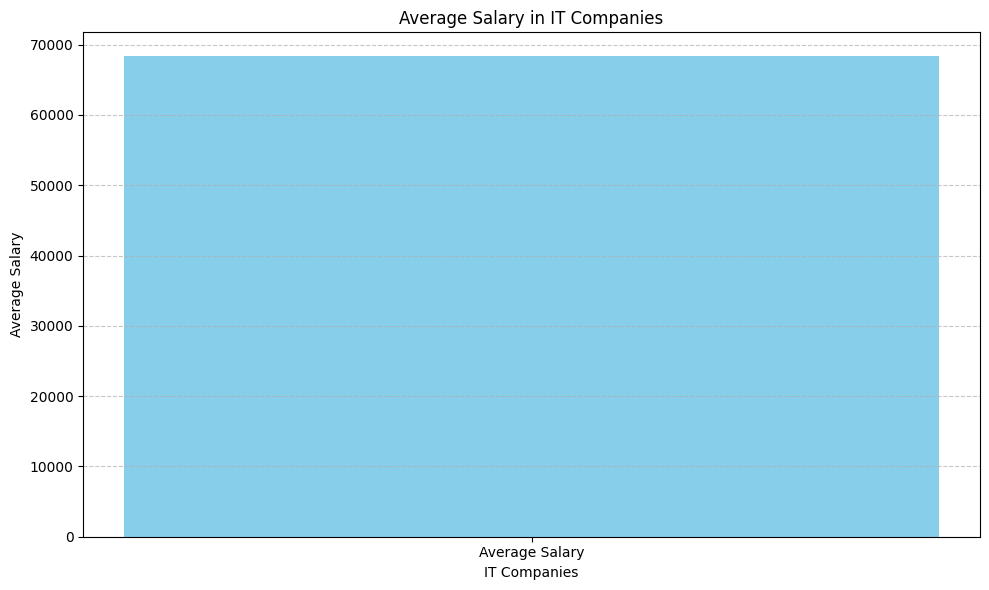

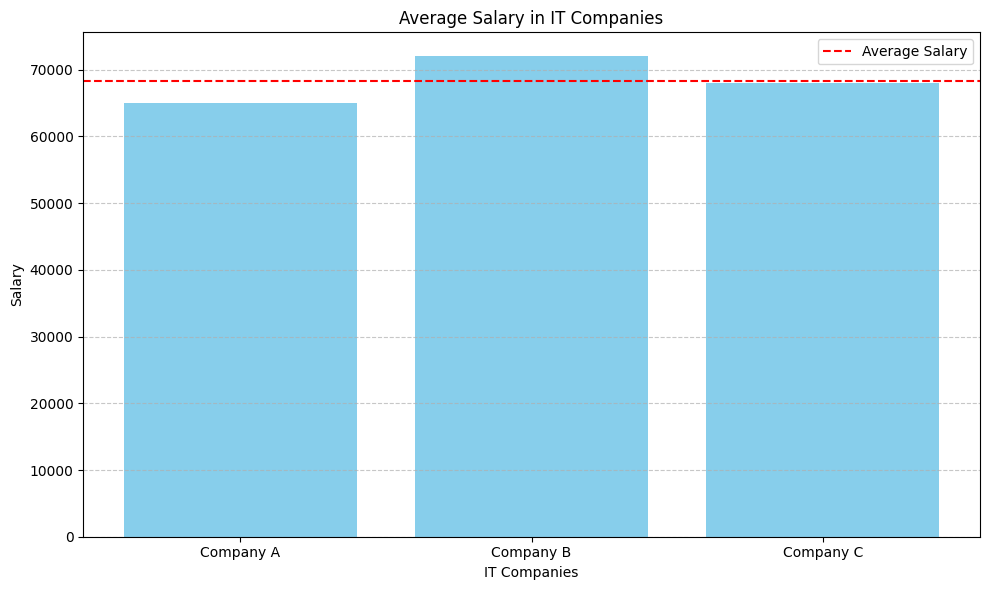

Traceback (most recent call last):
  File "/Users/alejandro/Documents/Repositorios/alejandromadrid/.python-venv/lib/python3.9/site-packages/pandasai/pipelines/chat/code_execution.py", line 85, in execute
    result = self.execute_code(code_to_run, code_context)
  File "/Users/alejandro/Documents/Repositorios/alejandromadrid/.python-venv/lib/python3.9/site-packages/pandasai/pipelines/chat/code_execution.py", line 175, in execute_code
    raise NoResultFoundError("No result returned")
pandasai.exceptions.NoResultFoundError: No result returned

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/alejandro/Documents/Repositorios/alejandromadrid/.python-venv/lib/python3.9/site-packages/pandasai/pipelines/chat/generate_chat_pipeline.py", line 307, in run
    output = (self.code_generation_pipeline | self.code_execution_pipeline).run(
  File "/Users/alejandro/Documents/Repositorios/alejandromadrid/.python-venv/lib/python3.9/si

'Unfortunately, I was not able to answer your question, because of the following error:\n\nNo code found in the response\n'

In [67]:
df = SmartDataframe([{}])
df.chat(text)


##### Lib problem

To ask correctly to PandasAI, we need to ask about out data (dataframes) and we are asking to pandasAI a question over an empty dataframe so we can't ask to plot anything cause pandasAI works with our dataframes.

To solve this problem, we need to rewrite the idea of the python application. 

For the new point of view, i'm going to use a pre-trained Transformer model with the parsed audio record and make the program talk the answer given by the algorithm.